In [1]:
""" AHP_4L_with_sensit_analysis_CleanEnergy.ipynb """
import numpy as np
from scipy import stats
from scipy.optimize import root
import matplotlib.pyplot as plt
""" Solve a complete 4-level AHP model and perform sensitivity analysis
    on the weights on main and sub-criteria. """

' Solve a complete 4-level AHP model and perform sensitivity analysis\n    on the weights on main and sub-criteria. '

In [2]:
""" Load all helper functions """
def sensit(C, S, AL, u, v, W):
    """ Perform Sensitivty Analysis """

    # Sensitivity Analysis on main criteria weight
    for k, cr in enumerate(C):
        adj_WG_dict = {}
        for p in np.linspace(0,1,11):
            adj_u = renorm_wt(p, k, u)
            adj_vG = {}
            for i, (c, z) in enumerate(v.items()):
                adj_vG[c] = adj_u[i]*z
            adj_wG = sum([ np.dot(W[c], adj_vG[c]) for c in C ])
            adj_WG_dict[p] = adj_wG
        rainbow_diagram(adj_WG_dict, AL, cr, base_val=u[k])

    # Sensitivty analysis on sub-criteria weights
    for cr in C:
        for k, sc in enumerate(S[cr]):
            adj_v = dict(v) # make a deep copy
            adj_WG_dict = {}
            for p in np.linspace(0,1,11):
                adj_v[cr] = renorm_wt(p, k, v[cr])
                adj_vG = {}
                for i, (cx, z) in enumerate(adj_v.items()):
                    adj_vG[cx] = u[i]*z
                adj_wG = sum([ np.dot(W[c], adj_vG[c]) for c in C ])
                adj_WG_dict[p] = adj_wG
            rainbow_diagram(adj_WG_dict, AL, cr, sub_cr=sc, base_val=v[cr][k])
    
            
def rainbow_diagram(w_dict, alternatives, main_cr, sub_cr=None, base_val=None):
    """ Plot the rainbow diagram 
    Parameters:
      w = dictionary of array of alternative weights of the form
            { p : [w1, w2, ..., wn ]  where 0 <= p <= 1.
      alternatives = list of alternatives
      main_cr = main criterion name
      sub_cr = sub-criterion name if any
      base_val = base value of criterion being varied
    """ 
    
    fig, ax = plt.subplots(figsize=(10,8))
    ax.plot(w_dict.keys(), w_dict.values(), 
             label=alternatives, lw='2')
    if base_val is not None:
        ax.plot([base_val, base_val], [0, 1], '--', color='black')
   
    if sub_cr is None:
        ax.set_title(f"Rainbow diagram for main criterion {main_cr}", 
             fontsize='x-large')
        ax.set_xlabel(f"Weight of main criterion {main_cr}", 
                 fontsize='x-large')
    else:
        ax.set_title(f"Rainbow diagram for sub-criterion {main_cr} > {sub_cr}", 
            fontsize='x-large')
        ax.set_xlabel(f"Weight of sub-criterion {main_cr} > {sub_cr}", 
                fontsize='x-large')
     
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xticks(np.linspace(0,1,11))
    ax.set_yticks(np.linspace(0,1,11))
    ax.set_ylabel('Weight of Alternatives', fontsize='x-large')
    ax.legend(fontsize='x-large')
    ax.grid()
    plt.show()


def renorm_wt(p, k, base_wt):
    """ Renormalize the weights when one weight is changed while keeping 
        all the other weights at their original base value proportions 
    Parameters:
        p = new value between 0 and 1
        k = index between 0 and n-1
        base_wt = base weights
    Returns:
        a renormalized weight vector 
    """
 
    new_wt = base_wt.copy()
    bal_wt = base_wt.sum() - base_wt[k]
    for i, w in enumerate(base_wt):
        if i != k:
            new_wt[i] = (1-p)*base_wt[i]/bal_wt
    new_wt[k] = p
    return new_wt


def AHPmat(A, method='Power'):
    """ Comput AHP matrix A using chosen method
    Parameter:  A = matrix to evaluate
    Returns:    w, lambda_max, CI, CR
    """
    RI=(0.58,0.90,1.12,1.24,1.32,1.41,1.45,1.49,1.51,1.54,1.56,1.57,1.58) 

    def Power(A):
        """ Compute the AHP matrix A using Power Iterations method.
            Parameter:  A = matrix to evaluate
            Returns:    w, lambda_max, CI, CR
        """
        gm = stats.gmean(A, axis=1)   # Use RGM method as initial value
        w = gm/gm.sum()
        max_iter= 1000000
        epsilon = 1.E-12
        for iter in range(max_iter):
            w1 = np.dot(A,w)    # w(k+1) = A w(k) 
            w1 = w1/w1.sum()    # normalize w(k+1)
            if all(np.absolute(w1-w) < epsilon):
                w = w1
                break
            w = w1
        lambda_max = (np.dot(A,w)/w).mean()
        n, _ = A.shape
        CI = (lambda_max-n)/(n-1)
        CR = 0 if n==2 else CI/RI[n-3]
        return w, lambda_max, CI, CR
    
    def Algebra(A):
        """ Compute the AHP matrix A using Power Iterations method.
            Parameter:  A = matrix to evaluate
            Returns:    w, lambda_max, CI, CR
        """            
        n, _ = A.shape
        # Solve for lambda such that Det(A - lambda*I) = 0
        sol = root(lambda x: np.linalg.det(A-np.eye(n)*x), n)
        lambda_max = sol.x[0]
        # Find w by solving a set of linear equations M w = b
        # M = A - lambda_max I for first n-1 rows
        M = A - np.eye(n)*lambda_max  
        # Replace the last row with [1, 1..., 1]
        M[n-1] = np.ones(n)
        b = np.append(np.zeros(n-1), [1])  # b = [0, 0, ..., 1]
        w = np.linalg.solve(M,b)
        CI = (lambda_max-n)/(n-1)
        CR = 0 if n == 2 else CI/RI[n-3]
        return w, lambda_max, CI, CR
    
    def RGM(A):
        """ Compute the AHP matrix A using the RGM approximation method.
            Parameter:  A = matrix to evaluate
            Returns:    w, lambda_max, CI, CR
        """           
        n, _ = A.shape
        gm = stats.gmean(A, axis=1)   
        w = gm/gm.sum()
        lambda_max = (np.dot(A,w)/w).mean()
        CI = (lambda_max-n)/(n-1)
        CR = 0 if n==2 else CI/RI[n-3]
        return w, lambda_max, CI, CR
    
    # We just need the w vector.
    if method=='Power':
        return Power(A)[0]
    elif method=='Algebra':
        return Algebra(A)[0]
    elif method=='RGM':
        return RGM(A)[0]
    else:
        print("Invalid method chosen")
        exit()


In [3]:
""" Solve the Clean Energy Problem """
    
# Goal
G = 'Substainable Clean Energy Technology'

# Main citeria and Sub-Criteria
S = {'Technical': ['Technology readiness',
                   'Safety',
                   'Efficiency',
                   'Useful life' ],
     'Economic': ['Investment cost',
                  'O&M costs',
                  'Feed-in-Tariff'],
     'Environmental': ['CO2 emission',
                       'Land use',
                       'Water consumption'],
     'Social & Policy': ['Job creation',
                         'Projected capacity']
     }

C = list(S.keys())

# Alternatives
AL = ['Solar PV','Wind','Nuclear','Biomass']

In [4]:
 # Main criteria wrt Goal
AG = np.array([[1,  1,  1/5, 1/2],
               [1,  1,  1/5, 1/2],
               [5,  5,   1,   3 ],
               [2,  2,  1/3,  1 ]])

In [5]:
# Main criteria weights 
u = AHPmat(AG, method='Algebra')

print("\nMain criteria weights")
for i, cr in enumerate(C):
    print(f"  {cr:15} : {u[i]:.6f}")


Main criteria weights
  Technical       : 0.109270
  Economic        : 0.109270
  Environmental   : 0.572450
  Social & Policy : 0.209009


In [6]:
# Sub-Criteria under 'Technical'
A1 = np.array([[ 1,   1,  3,  1 ],
               [ 1,   1,  3,  1 ],
               [1/3, 1/3, 1, 1/2],
               [ 1,   1,  2,  1 ]])

# Sub-Criteria under 'Economic'
A2 = np.array([[1, 1/9, 1/5],
                [9,  1,   4 ],
                [5, 1/4,  1 ]])

# Sub-Criteria under 'Environmental'
A3 = np.array([[1, 1/4, 1/3],
               [4,  1,   1 ],
               [3,  1,   1 ]])

# Sub-Criteria under 'Social & Policy'
A4 = np.array([[ 1,  2],
               [1/2, 1]])

In [7]:
# Sub-crieria weights
v = { cr : AHPmat(A, method='Algebra') for cr, A in zip(C,[A1,A2,A3,A4]) }

for cr, z in v.items():
    print(f"\nSub-criteria weights wrt {cr}")
    for wj, s in zip(z, S[cr]):
        print(f"  {s:20} : {wj:.6f}")


Sub-criteria weights wrt Technical
  Technology readiness : 0.304999
  Safety               : 0.304999
  Efficiency           : 0.113143
  Useful life          : 0.276859

Sub-criteria weights wrt Economic
  Investment cost      : 0.060328
  O&M costs            : 0.708524
  Feed-in-Tariff       : 0.231148

Sub-criteria weights wrt Environmental
  CO2 emission         : 0.126005
  Land use             : 0.457934
  Water consumption    : 0.416061

Sub-criteria weights wrt Social & Policy
  Job creation         : 0.666667
  Projected capacity   : 0.333333


In [8]:
# Sub-criteria global weights
vG = {}
for i, (cr, z) in enumerate(v.items()):
    vG[cr] = u[i]*z

In [9]:
# Alternatives w.r.t. sub-criteria under 'Technical'
# 'Technologial readiness'
A11 = np.array([[ 1,   1,  3,  2 ],
                [ 1,   1,  3,  2,],
                [1/3, 1/3, 1, 1/2],
                [1/2, 1/2, 2,  1 ]])

# 'Safety'
A12 = np.array([[ 1,   2,  3, 1/2],
                [1/2,  1,  2, 1/2],
                [1/3, 1/2, 1, 1/4],
                [ 2,   2,  4,  1]])

# 'Efficiency'
A13 = np.array([[1, 1/2, 1/2, 1/2],
                [2,  1,   1,   2 ],
                [2,  1,   1,   1 ],
                [2,  1/2, 1,   1 ]])

# 'Useful life'
A14 = np.array([[1, 1, 1/2,  1 ],
                [1, 1, 1/3, 1/2],
                [2, 3,  1,   3 ],
                [1, 2, 1/3,  1 ]])


# Alternatives w.r.t. sub-criteria under 'Economic'
# 'Investment cost'
A21 = np.array([[1, 1/2,  1, 1],
                 [2,  1,   2, 2],
                 [1,  1/2, 1, 1],
                 [1,  1/2, 1, 1]])  

# 'O&M costs'
A22 = np.array([[ 1,  2, 1/3, 1/7],
                [1/2, 1, 1/3, 1/9],
                [ 3,  3,  1,  1/3],
                [ 7,  9,  3,	 1 ]])

# 'Feed-in-Tariff'
A23 = np.array([[1, 1/2, 1/2, 1/2],
                [2,  1,   1,	2 ],
                [2,  1,   1,   1 ],
                [2, 1/2,  1,   1 ]])


# Alternatives w.r.t. sub-criteria under 'Environmental'
# 'CO2 emission'
A31 = np.array([[ 1, 1/2,  1/2, 3],
                [ 2,  1,   1/2, 5],
                [ 2,  2,    1,  5],
                [1/3, 1/5, 1/5, 1]])

# 'Land use'
A32 = np.array([[ 1,   8,   7,  9],
                [1/8,  1,   1,  4],
                [1/7,  1,   1,  4],
                [1/9, 1/4, 1/4, 1]])

# 'Water consumption'
A33 = np.array([[ 1, 1/2,  9,  8 ],
                [ 2,  1,   9,  9 ],
                [1/9, 1/9, 1, 1/2],
                [1/8, 1/9, 2,  1 ]])

# Alternatives w.r.t. sub-criteria under 'Social & Policy'
# 'Job creation'
A41 = np.array([[ 1,  5, 6,  4 ],
                [1/5, 1, 1,  1 ],
                [1/6, 1, 1, 1/2],
                [1/4, 1, 2,  1 ]])

# 'Projected capacity'
A42 = np.array([[ 1, 1/5,  2, 1/2],
                [ 5,  1,   7,  2 ],
                [1/2, 1/7, 1, 1/3],
                [ 2,  1/2, 3,  1 ]])

In [10]:
method = 'Algebra'
W = {}
# Technical
W[C[0]] = np.array([AHPmat(A, method=method)
                    for A in [A11,A12,A13,A14]]).T
# Economic
W[C[1]] = np.array( [AHPmat(A, method=method) 
                    for A in [A21,A22,A23]]).T

# Environmental
W[C[2]] = np.array([AHPmat(A, method=method) 
                    for A in [A31,A32,A33]]).T

# Social & Policy
W[C[3]] = np.array([AHPmat(A, method=method)
                    for A in [A41,A42]]).T

print("\nAlternatives' local weights")
for cr in C:
    for j, s in enumerate(S[cr]):
        print(f"\n  {cr} > {s}")
        for k, en in enumerate(AL):
            print(f"    {en:9s}: {W[cr][k,j]:.6f}")


Alternatives' local weights

  Technical > Technology readiness
    Solar PV : 0.350913
    Wind     : 0.350913
    Nuclear  : 0.109114
    Biomass  : 0.189060

  Technical > Safety
    Solar PV : 0.286323
    Wind     : 0.182003
    Nuclear  : 0.096899
    Biomass  : 0.434775

  Technical > Efficiency
    Solar PV : 0.140424
    Wind     : 0.339710
    Nuclear  : 0.280848
    Biomass  : 0.239018

  Technical > Useful life
    Solar PV : 0.188380
    Wind     : 0.144399
    Nuclear  : 0.462341
    Biomass  : 0.204880

  Economic > Investment cost
    Solar PV : 0.200000
    Wind     : 0.400000
    Nuclear  : 0.200000
    Biomass  : 0.200000

  Economic > O&M costs
    Solar PV : 0.094454
    Wind     : 0.062475
    Nuclear  : 0.222439
    Biomass  : 0.620632

  Economic > Feed-in-Tariff
    Solar PV : 0.140424
    Wind     : 0.339710
    Nuclear  : 0.280848
    Biomass  : 0.239018

  Environmental > CO2 emission
    Solar PV : 0.188624
    Wind     : 0.306684
    Nuclear  : 0.435730
 

In [11]:
# Compute the Alternatives' Global weights
wG = sum([ np.dot(W[cr], vG[cr]) for cr in C ])

print(f"\nAlternatives' weights wrt {G}")
for i, energy in enumerate(AL):
    print(f"  {energy:9s}: {wG[i]:.6f}")


Alternatives' weights wrt Substainable Clean Energy Technology
  Solar PV : 0.421290
  Wind     : 0.279321
  Nuclear  : 0.143571
  Biomass  : 0.155818


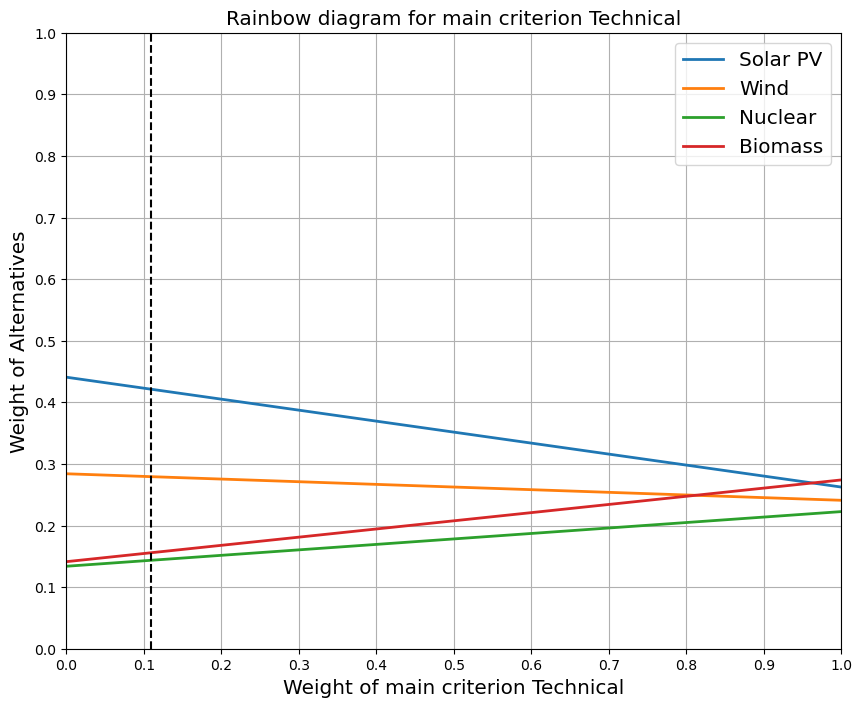

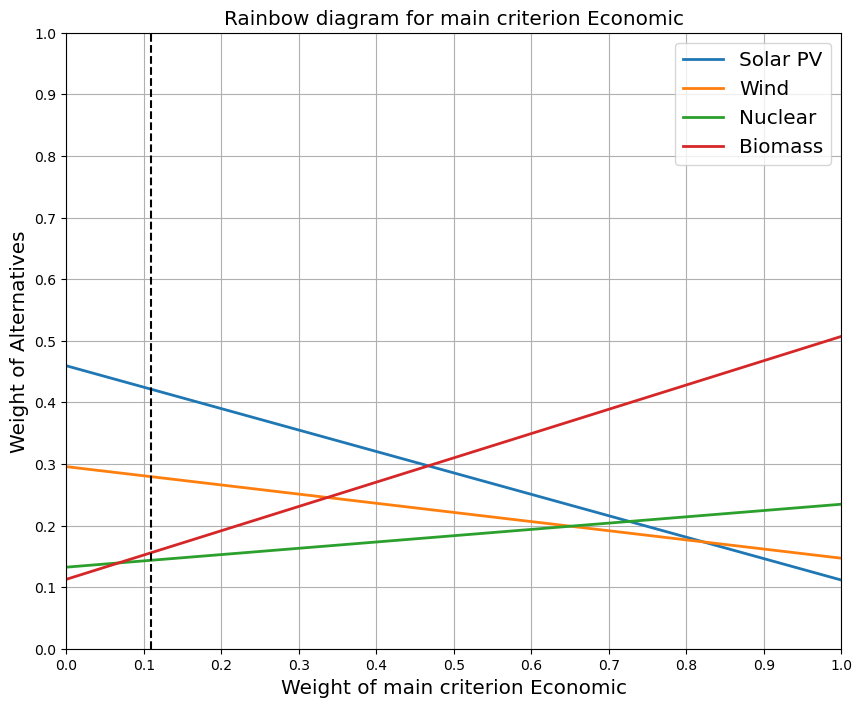

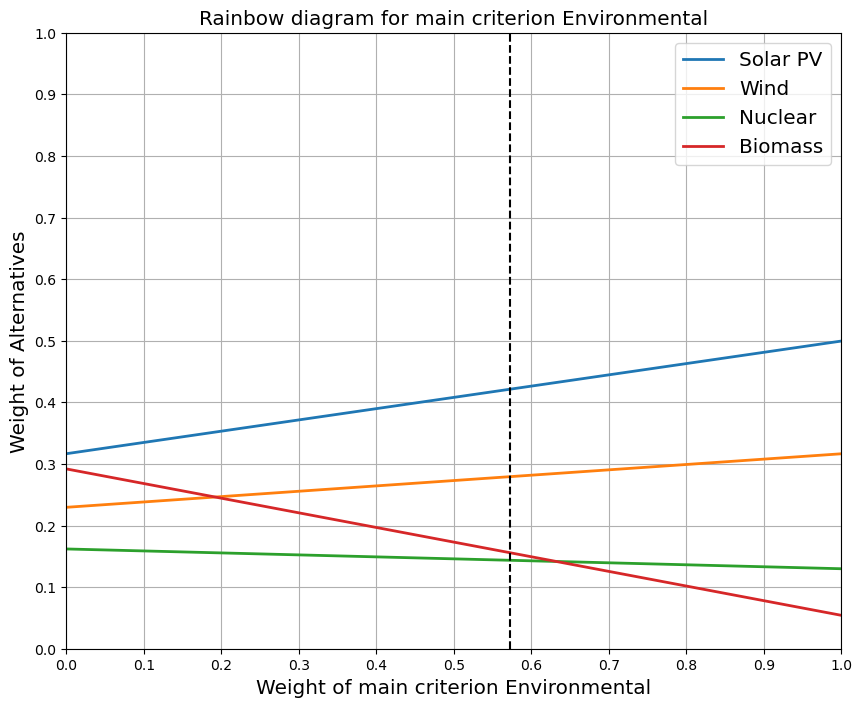

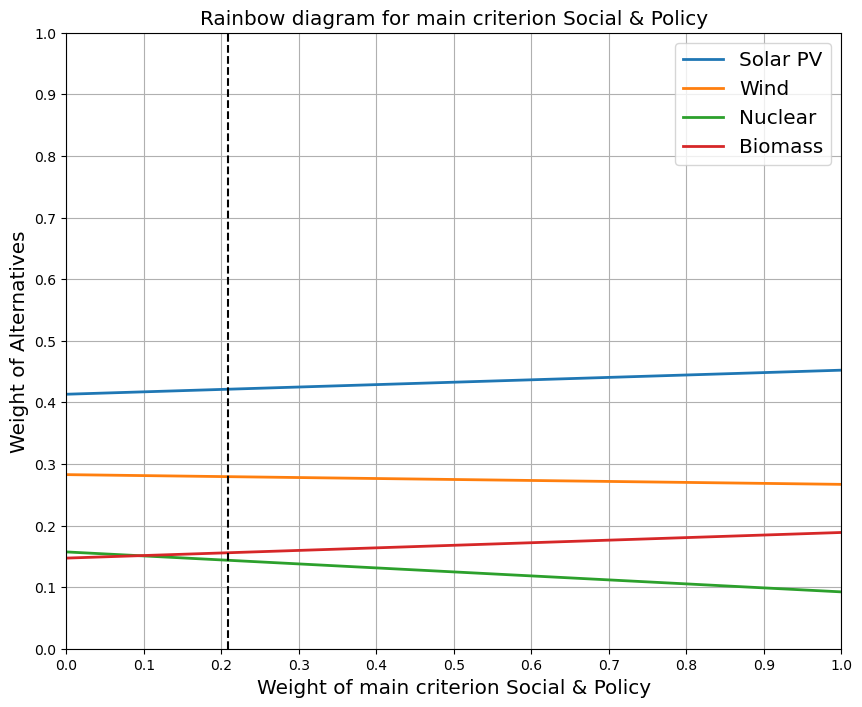

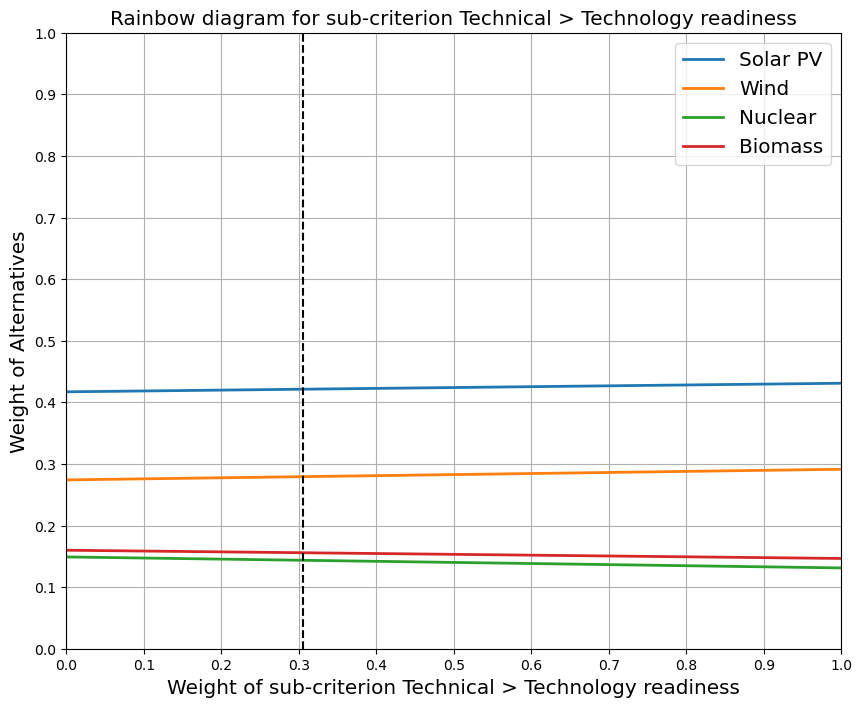

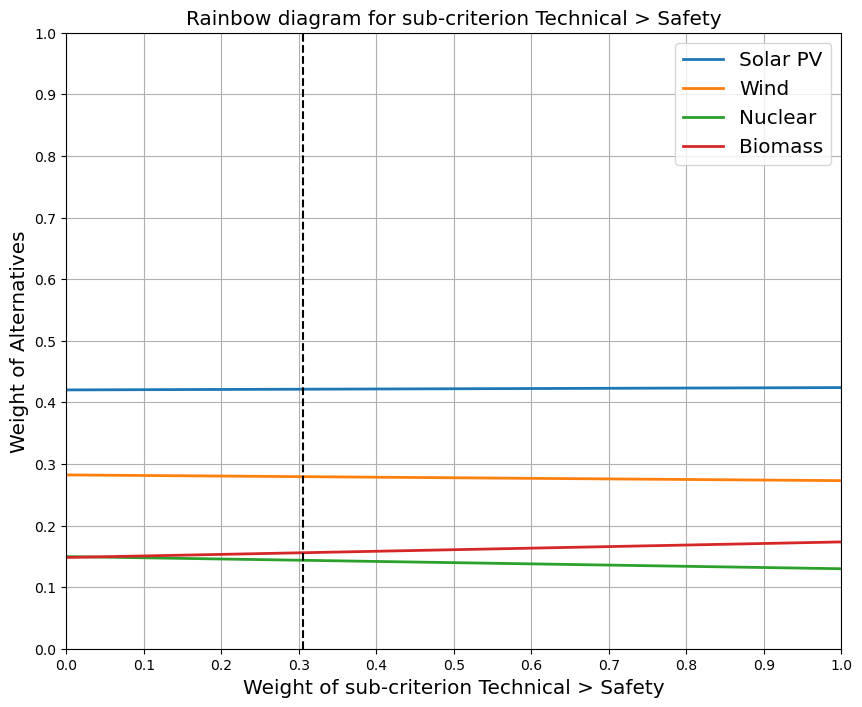

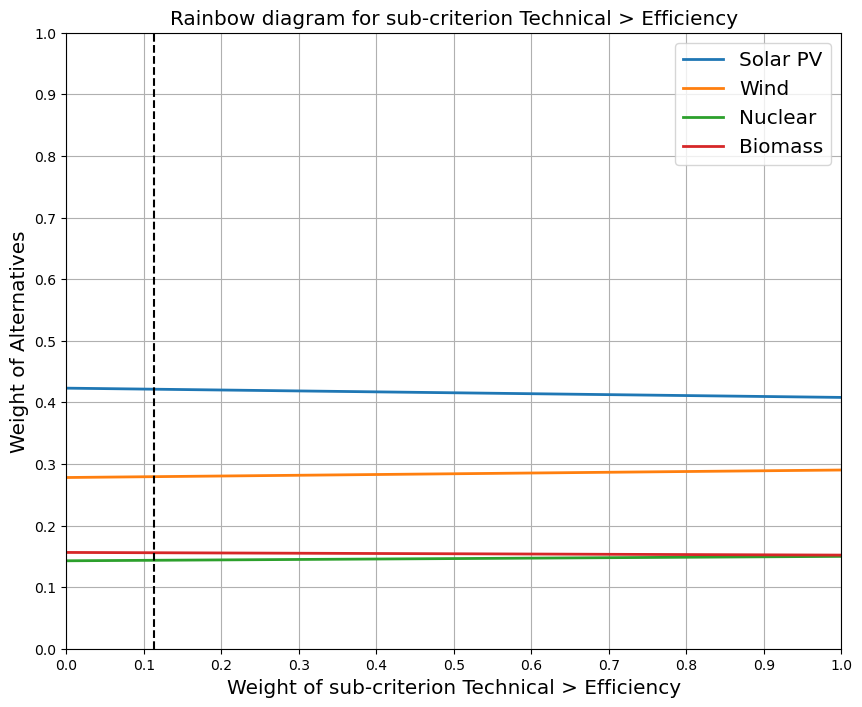

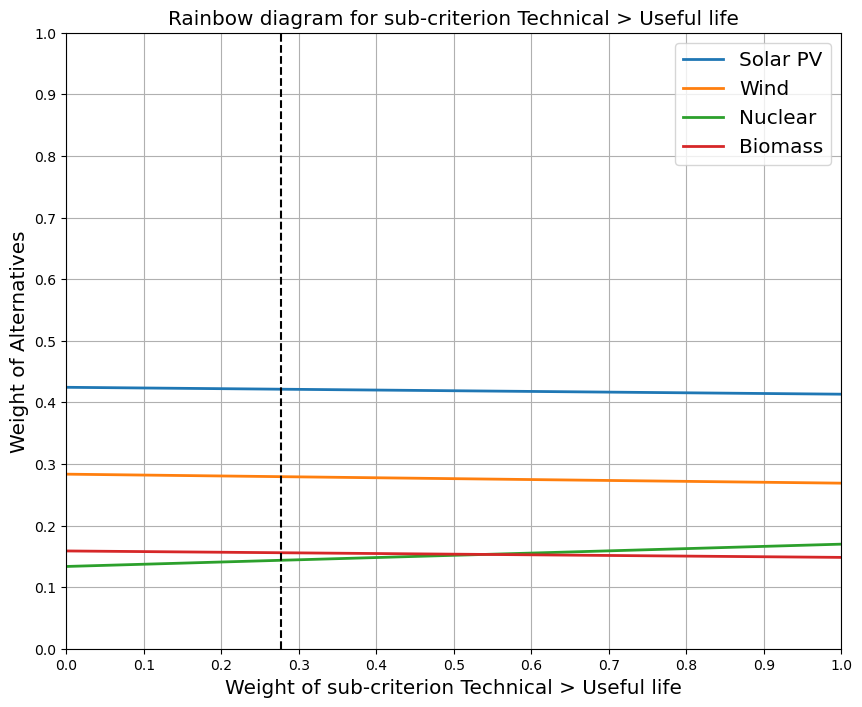

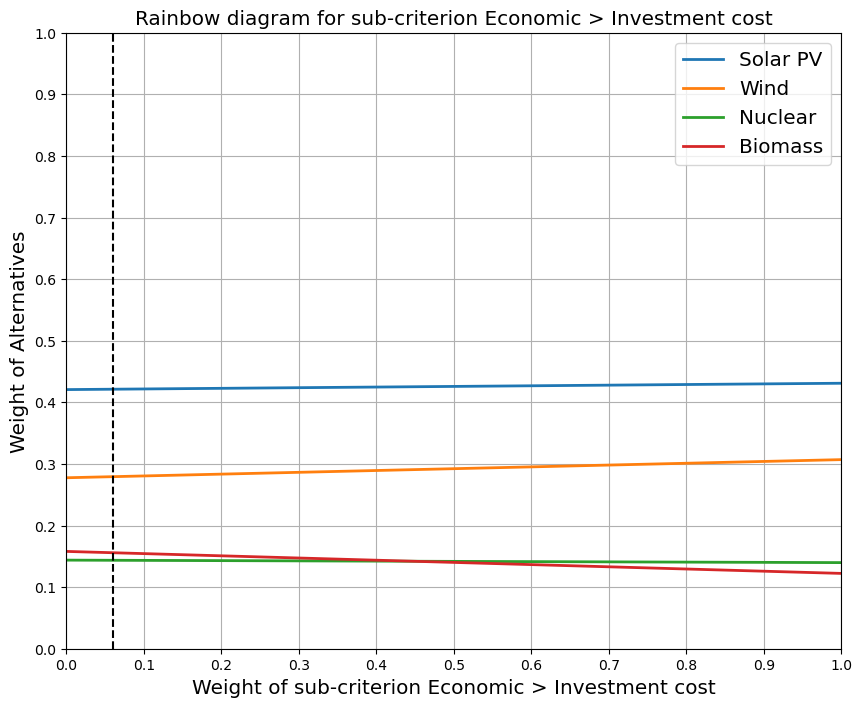

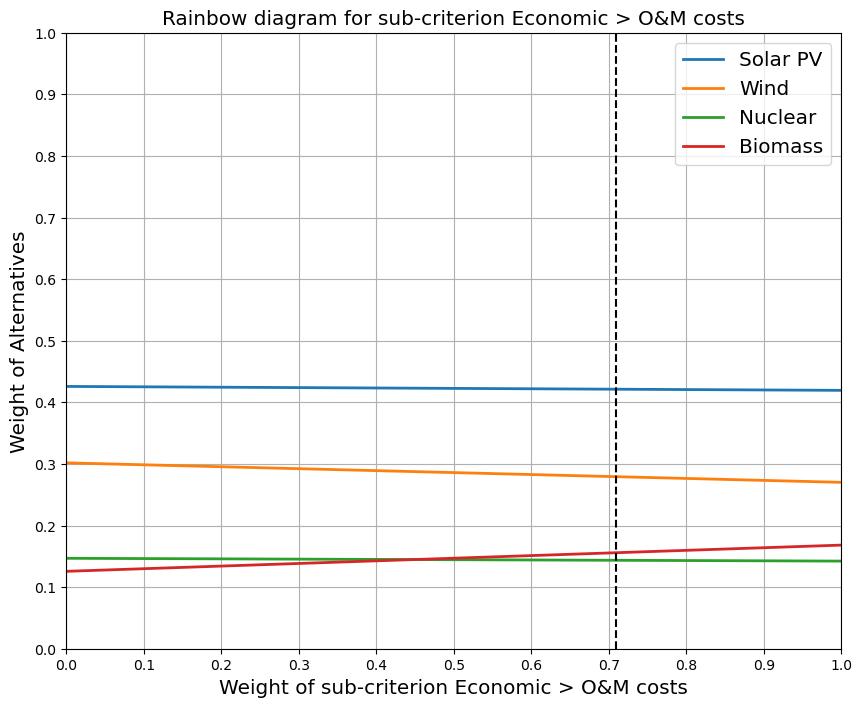

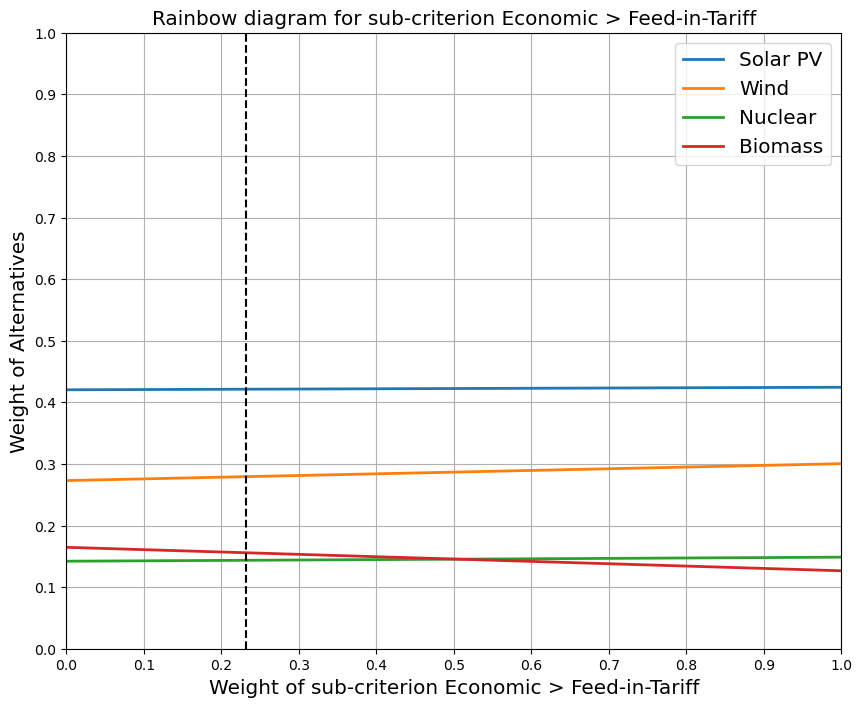

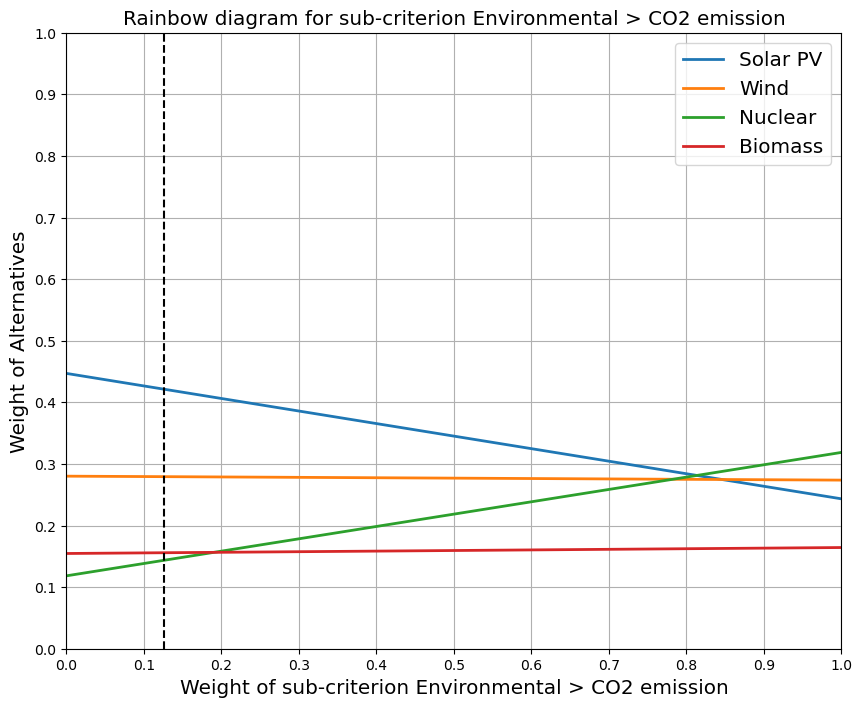

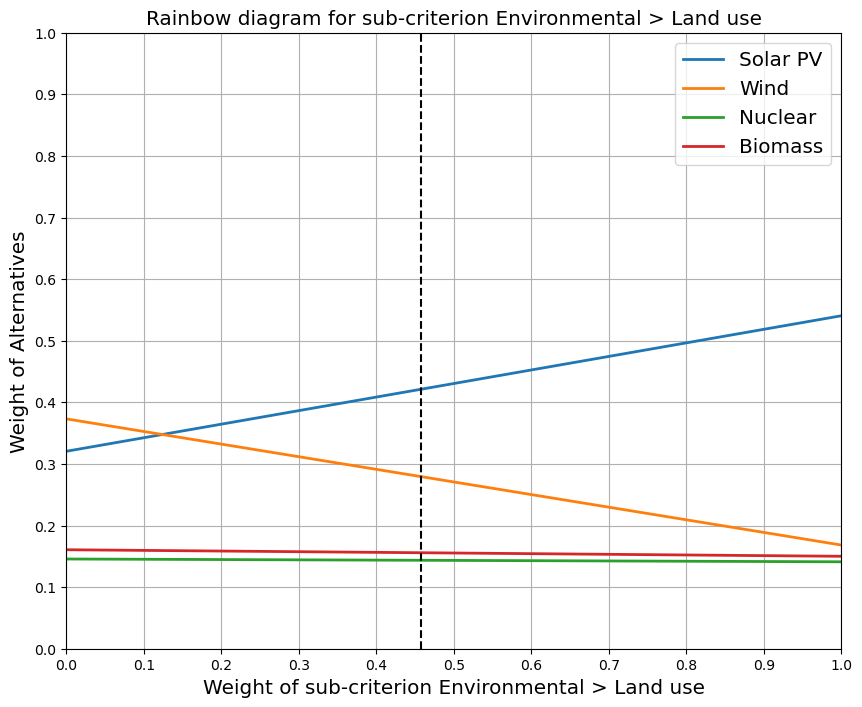

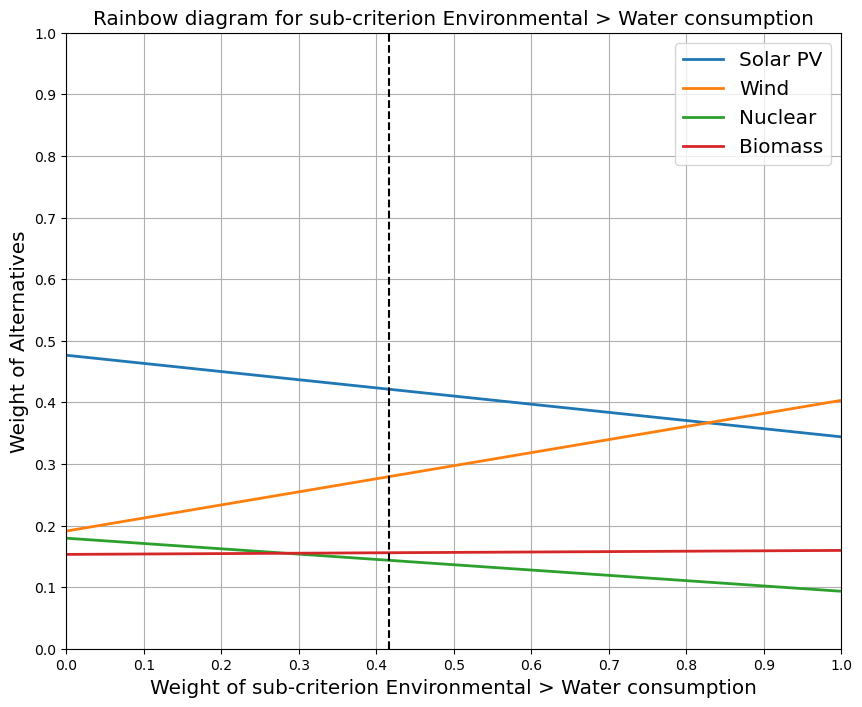

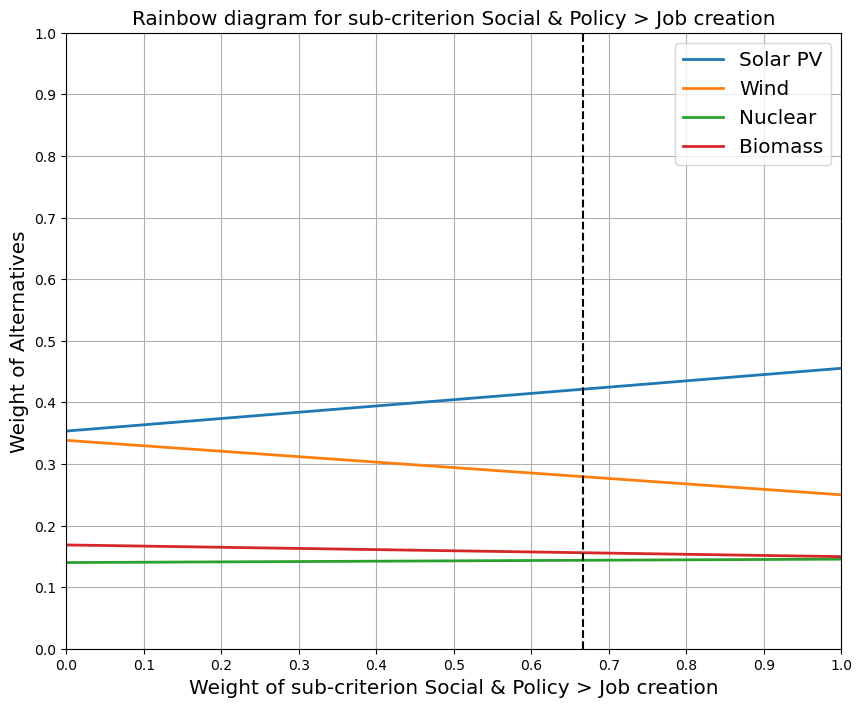

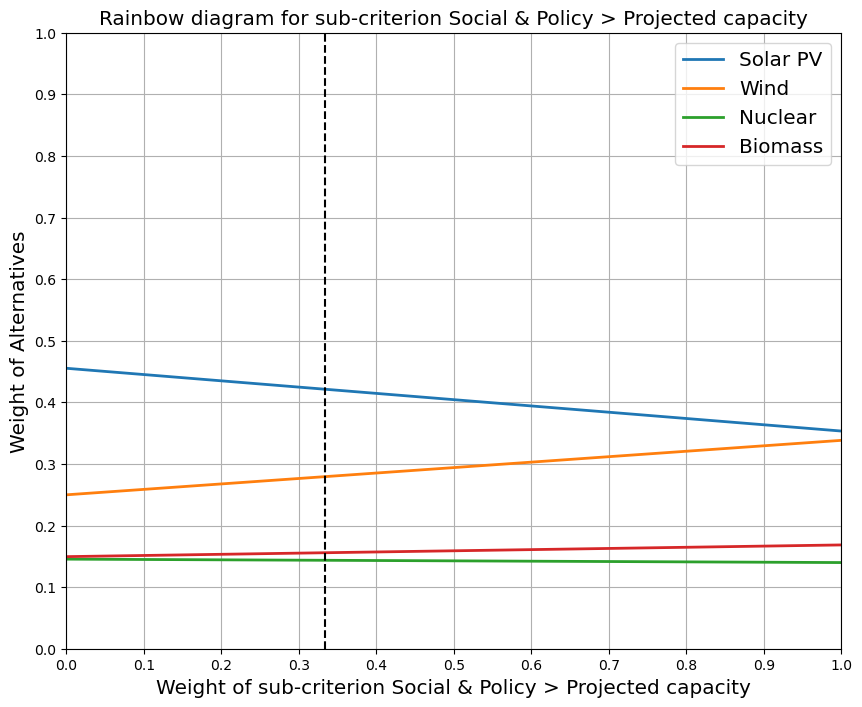

In [12]:
# Perform Sensitivity Analysis
sensit(C, S, AL, u, v, W)
   